In [2]:
from google.colab import files
uploaded = files.upload()

Saving DecisionTree_y_pred.csv to DecisionTree_y_pred.csv
Saving heart_disease_only.csv to heart_disease_only.csv
Saving NaiveBayes_output.csv to NaiveBayes_output.csv
Saving Softmax_Output_For_Stacking.csv to Softmax_Output_For_Stacking.csv
Saving svm_predictions_only.csv to svm_predictions_only.csv


In [24]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import

In [25]:
import os, time, json
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

BASE_DIR = "."

PATH_YTRUE   = os.path.join(BASE_DIR, "heart_disease_only.csv")
PATH_SVM     = os.path.join(BASE_DIR, "svm_predictions_only.csv")
PATH_NB      = os.path.join(BASE_DIR, "NaiveBayes_output.csv")
PATH_TREE    = os.path.join(BASE_DIR, "DecisionTree_y_pred.csv")
PATH_SOFTMAX = os.path.join(BASE_DIR, "Softmax_Output_For_Stacking.csv")

COL_YTRUE   = "HeartDisease"
COL_SVM     = "svm_pred"
COL_NB      = "NB_Predicted"
COL_TREE    = "y_pred"
COL_SOFTMAX = "Softmax_Label"

OUT_DIR = "stacking_runs"
os.makedirs(OUT_DIR, exist_ok=True)

Save merged

In [17]:
def load_bin_col(path, col):
    df = pd.read_csv(path)
    if col not in df.columns:
        raise ValueError(f"File {path} không có cột '{col}'. Cột hiện có: {df.columns.tolist()}")
    x = df[col].to_numpy().astype(int)
    uniq = set(np.unique(x).tolist())
    if not uniq.issubset({0, 1}):
        raise ValueError(f"{path} có giá trị không phải 0/1: {sorted(list(uniq))}")
    return x

y  = load_bin_col(PATH_YTRUE,   COL_YTRUE)
sv = load_bin_col(PATH_SVM,     COL_SVM)
nb = load_bin_col(PATH_NB,      COL_NB)
dt = load_bin_col(PATH_TREE,    COL_TREE)
sm = load_bin_col(PATH_SOFTMAX, COL_SOFTMAX)

n = len(y)
assert len(sv)==n and len(nb)==n and len(dt)==n and len(sm)==n, "Các file không cùng số dòng!"

df_stack = pd.DataFrame({
    "id": np.arange(n),
    "y_true": y,
    "svm_pred": sv,
    "nb_pred": nb,
    "dt_pred": dt,
    "softmax_pred": sm
})

MERGED_PATH = "stacking_input_merged.csv"
df_stack.to_csv(MERGED_PATH, index=False)

print("Merged df_stack:", df_stack.shape)
print("Class counts:", {0:int((y==0).sum()), 1:int((y==1).sum())})
print("Saved:", MERGED_PATH)

df_stack.head()

Merged df_stack: (40000, 6)
Class counts: {0: 20000, 1: 20000}
Saved: stacking_input_merged.csv


,id,y_true,svm_pred,nb_pred,dt_pred,softmax_pred
0,0,0,1,0,1,1
1,1,0,0,0,0,0
2,2,0,0,0,1,0
3,3,0,0,1,0,0
4,4,1,1,1,1,1


Tạo ma trận meta-features Z và nhãn y

In [27]:
import numpy as np
import pandas as pd

feature_cols = ["svm_pred", "nb_pred", "dt_pred", "softmax_pred"]

X = df_stack[feature_cols].to_numpy(dtype=float)
y = df_stack["y_true"].to_numpy(dtype=int)

print("X:", X.shape, "y:", y.shape)

X shape: (40000, 4) | y shape: (40000,)


Chia dữ liệu 80/20 (stratified)

In [28]:
def stratified_split_indices(y, test_size=0.2, seed=42):
    rng = np.random.default_rng(seed)
    idx0 = np.where(y==0)[0]
    idx1 = np.where(y==1)[0]
    rng.shuffle(idx0); rng.shuffle(idx1)

    n0_test = int(round(test_size * len(idx0)))
    n1_test = int(round(test_size * len(idx1)))

    test_idx = np.concatenate([idx0[:n0_test], idx1[:n1_test]])
    train_idx = np.concatenate([idx0[n0_test:], idx1[n1_test:]])
    rng.shuffle(test_idx); rng.shuffle(train_idx)
    return train_idx, test_idx

train_idx, test_idx = stratified_split_indices(y, test_size=0.2, seed=42)
X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Train size:", len(y_train), "Test size:", len(y_test))
print("Train class:", {0:int((y_train==0).sum()), 1:int((y_train==1).sum())})
print("Test class :", {0:int((y_test==0).sum()),  1:int((y_test==1).sum())})


Train size: 32000 Test size: 8000
Train class: {0: 16000, 1: 16000}
Test class : {0: 4000, 1: 4000}


Tách Validation từ Train

In [29]:
def stratified_val_split_indices(y, val_size=0.1, seed=123):
    rng = np.random.default_rng(seed)
    idx0 = np.where(y==0)[0]
    idx1 = np.where(y==1)[0]
    rng.shuffle(idx0); rng.shuffle(idx1)

    n0_val = int(round(val_size * len(idx0)))
    n1_val = int(round(val_size * len(idx1)))

    val_idx = np.concatenate([idx0[:n0_val], idx1[:n1_val]])
    tr_idx  = np.concatenate([idx0[n0_val:], idx1[n1_val:]])
    rng.shuffle(val_idx); rng.shuffle(tr_idx)
    return tr_idx, val_idx

tr_idx, val_idx = stratified_val_split_indices(y_train, val_size=0.1, seed=123)
X_tr, y_tr   = X_train[tr_idx], y_train[tr_idx]
X_val, y_val = X_train[val_idx], y_train[val_idx]

print("X_tr:", X_tr.shape, "X_val:", X_val.shape)

X_tr: (28800, 4) X_val: (3200, 4)


Hàm logistic

In [30]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def add_bias(X):
    return np.c_[np.ones(len(X)), X]

def predict_proba(X, w):
    return sigmoid(add_bias(X) @ w)

Class weight

In [31]:
def compute_class_weights(y):
    n0 = int((y==0).sum())
    n1 = int((y==1).sum())
    total = len(y)
    w0 = total / (2*n0 + 1e-9)
    w1 = total / (2*n1 + 1e-9)
    return {0: w0, 1: w1}

cw = compute_class_weights(y_tr)
print("Class weights:", cw)

Class weights: {0: 0.9999999999999653, 1: 0.9999999999999653}


Train Logistic Regression + lưu loss

In [36]:
grid = [
    {"lr": 0.05, "epochs": 2000, "l2": 0.0},
    {"lr": 0.10, "epochs": 2000, "l2": 0.0},
    {"lr": 0.10, "epochs": 4000, "l2": 0.0},
    {"lr": 0.10, "epochs": 8000, "l2": 0.0},
    {"lr": 0.10, "epochs": 2000, "l2": 0.001},
    {"lr": 0.10, "epochs": 2000, "l2": 0.01},
]

results = []
cw = compute_class_weights(y_tr)
print("Class weights:", cw)

for i, g in enumerate(grid, 1):
    print(f"\n=== RUN {i} === {g}")

    w_i, history_i = train_logistic_gd_with_history(
        X_tr, y_tr,
        lr=g["lr"], epochs=g["epochs"], l2=g["l2"],
        class_weight=cw, log_every=200
    )

    val_proba = predict_proba(X_val, w_i)
    best_t, best_f1 = 0.5, -1
    for t in np.arange(0.05, 0.96, 0.01):
        pred = (val_proba >= t).astype(int)
        _, _, _, f1v, _ = manual_metrics(y_val, pred)
        if f1v > best_f1:
            best_f1 = f1v
            best_t = float(t)

    test_proba = predict_proba(X_test, w_i)
    test_pred  = (test_proba >= best_t).astype(int)
    acc, prec, rec, f1, cm = manual_metrics(y_test, test_pred)

    results.append({
        "run": i,
        "lr": g["lr"],
        "epochs": g["epochs"],
        "l2": g["l2"],
        "best_threshold_val": best_t,
        "val_f1": best_f1,
        "test_accuracy": acc,
        "test_precision": prec,
        "test_recall": rec,
        "test_f1": f1,
        "TN": cm[0], "FP": cm[1], "FN": cm[2], "TP": cm[3],
        "w0_bias": float(w_i[0]),
        "w_svm": float(w_i[1]),
        "w_nb": float(w_i[2]),
        "w_dt": float(w_i[3]),
        "w_softmax": float(w_i[4]),
        "history": history_i,
        "weights": w_i
    })

print("\nDone grid search. Total runs:", len(results))


Class weights: {0: 0.9999999999999653, 1: 0.9999999999999653}

=== RUN 1 === {'lr': 0.05, 'epochs': 2000, 'l2': 0.0}
Epoch     1 | loss=0.693147
Epoch   200 | loss=0.519669
Epoch   400 | loss=0.477393
Epoch   600 | loss=0.459127
Epoch   800 | loss=0.449192
Epoch  1000 | loss=0.442972
Epoch  1200 | loss=0.438733
Epoch  1400 | loss=0.435689
Epoch  1600 | loss=0.433425
Epoch  1800 | loss=0.431701
Epoch  2000 | loss=0.430364

=== RUN 2 === {'lr': 0.1, 'epochs': 2000, 'l2': 0.0}
Epoch     1 | loss=0.693147
Epoch   200 | loss=0.477460
Epoch   400 | loss=0.449209
Epoch   600 | loss=0.438740
Epoch   800 | loss=0.433428
Epoch  1000 | loss=0.430366
Epoch  1200 | loss=0.428475
Epoch  1400 | loss=0.427257
Epoch  1600 | loss=0.426446
Epoch  1800 | loss=0.425893
Epoch  2000 | loss=0.425510

=== RUN 3 === {'lr': 0.1, 'epochs': 4000, 'l2': 0.0}
Epoch     1 | loss=0.693147
Epoch   200 | loss=0.477460
Epoch   400 | loss=0.449209
Epoch   600 | loss=0.438740
Epoch   800 | loss=0.433428
Epoch  1000 | loss=

In [37]:
df_res = pd.DataFrame([{k:v for k,v in r.items() if k not in ["history","weights"]} for r in results])

df_show = df_res[[
    "run","lr","epochs","l2","best_threshold_val","val_f1",
    "test_accuracy","test_precision","test_recall","test_f1",
    "TN","FP","FN","TP"
]].sort_values(["test_f1","test_recall"], ascending=False)

df_show

,run,lr,epochs,l2,best_threshold_val,val_f1,test_accuracy,test_precision,test_recall,test_f1,TN,FP,FN,TP
0,1,0.05,2000,0.000,0.25,0.852732,0.84,0.805206,0.897,0.848628,3132,868,412,3588
1,2,0.10,2000,0.000,0.17,0.852732,0.84,0.805206,0.897,0.848628,3132,868,412,3588
2,3,0.10,4000,0.000,0.17,0.852732,0.84,0.805206,0.897,0.848628,3132,868,412,3588
3,4,0.10,8000,0.000,0.17,0.852732,0.84,0.805206,0.897,0.848628,3132,868,412,3588
4,5,0.10,2000,0.001,0.18,0.852732,0.84,0.805206,0.897,0.848628,3132,868,412,3588
5,6,0.10,2000,0.010,0.32,0.852732,0.84,0.805206,0.897,0.848628,3132,868,412,3588


In [39]:
best_run_id = int(df_show.iloc[0]["run"])
print("Best run id:", best_run_id)
best_obj = None
for r in results:
    if r["run"] == best_run_id:
        best_obj = r
        break

w = best_obj["weights"]
history = best_obj["history"]
best_t = float(best_obj["best_threshold_val"])

print("BEST RUN PARAMS:", {k: best_obj[k] for k in ["run","lr","epochs","l2","best_threshold_val","val_f1","test_f1","test_recall"]})

print("\nWeights (bias + per model):")
print("Bias (w0):", float(w[0]))
print("svm     :", float(w[1]))
print("nb      :", float(w[2]))
print("dt      :", float(w[3]))
print("softmax :", float(w[4]))
print("\nChosen threshold:", best_t)


Best run id: 1
BEST RUN PARAMS: {'run': 1, 'lr': 0.05, 'epochs': 2000, 'l2': 0.0, 'best_threshold_val': 0.25000000000000006, 'val_f1': 0.8527315914489311, 'test_f1': 0.848628192999054, 'test_recall': 0.897}

Weights (bias + per model):
Bias (w0): -1.9718483147616983
svm     : 2.6581832599004005
nb      : 0.46026001470463895
dt      : 0.18174002415519502
softmax : 0.19088680748126916

Chosen threshold: 0.25000000000000006


Tune threshold trên Validation (tối ưu F1)

In [40]:
def manual_confusion(y_true, y_pred):
    TP = int(np.sum((y_true==1)&(y_pred==1)))
    TN = int(np.sum((y_true==0)&(y_pred==0)))
    FP = int(np.sum((y_true==0)&(y_pred==1)))
    FN = int(np.sum((y_true==1)&(y_pred==0)))
    return TN, FP, FN, TP

def manual_metrics(y_true, y_pred):
    TN, FP, FN, TP = manual_confusion(y_true, y_pred)

    acc = (TP + TN) / (TP + TN + FP + FN)
    prec = 0 if (TP+FP)==0 else TP / (TP+FP)
    rec  = 0 if (TP+FN)==0 else TP / (TP+FN)
    f1   = 0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
    return acc, prec, rec, f1, (TN, FP, FN, TP)

val_proba = predict_proba(X_val, w)

best_t, best_f1 = 0.5, -1
for t in np.arange(0.05, 0.96, 0.01):
    pred = (val_proba >= t).astype(int)
    _, _, _, f1, _ = manual_metrics(y_val, pred)
    if f1 > best_f1:
        best_f1 = f1
        best_t = float(t)

print("Best threshold:", best_t)
print("Best val F1:", best_f1)

Best threshold: 0.25000000000000006
Best val F1: 0.8527315914489311


Dự đoán trên Test

In [42]:
test_proba = predict_proba(X_test, w)
test_pred  = (test_proba >= best_t).astype(int)

print("Made test_pred with threshold =", best_t)

Made test_pred with threshold = 0.25000000000000006


Accuracy/Precision/Recall/F1

In [43]:
import numpy as np

y_true = y_test.astype(int)
y_pred = test_pred.astype(int)

TP = np.sum((y_true == 1) & (y_pred == 1))
TN = np.sum((y_true == 0) & (y_pred == 0))
FP = np.sum((y_true == 0) & (y_pred == 1))
FN = np.sum((y_true == 1) & (y_pred == 0))

accuracy = (TP + TN) / (TP + TN + FP + FN)

precision = 0 if (TP + FP) == 0 else TP / (TP + FP)
recall    = 0 if (TP + FN) == 0 else TP / (TP + FN)
f1        = 0 if (precision + recall) == 0 else 2 * precision * recall / (precision + recall)

print("TN, FP, FN, TP:", (int(TN), int(FP), int(FN), int(TP)))
print("Accuracy :", float(accuracy))
print("Precision:", float(precision))
print("Recall   :", float(recall))
print("F1-score :", float(f1))

TN, FP, FN, TP: (3132, 868, 412, 3588)
Accuracy : 0.84
Precision: 0.8052064631956912
Recall   : 0.897
F1-score : 0.848628192999054


Loss theo Epoch

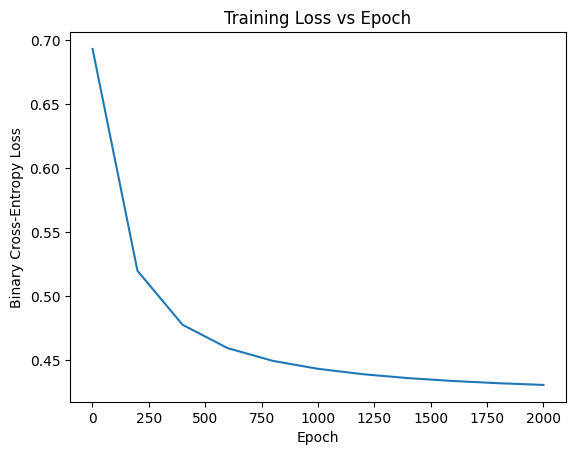

In [44]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history[:,0], history[:,1])
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss vs Epoch")
plt.show()


Confusion Matrix

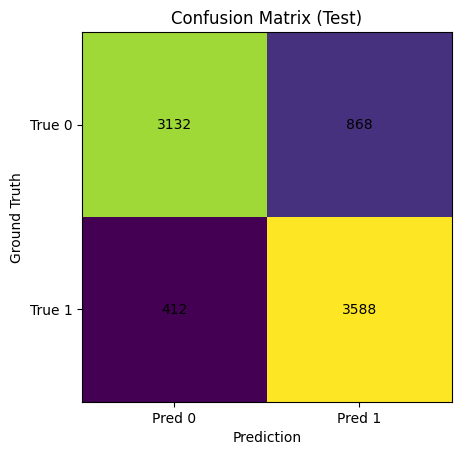

In [45]:
tn, fp, fn, tp = int(TN), int(FP), int(FN), int(TP)
cm = np.array([[tn, fp],
               [fn, tp]])

plt.figure()
plt.imshow(cm)
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i,j]), ha="center", va="center")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.show()


Trọng số meta-model theo từng base mode

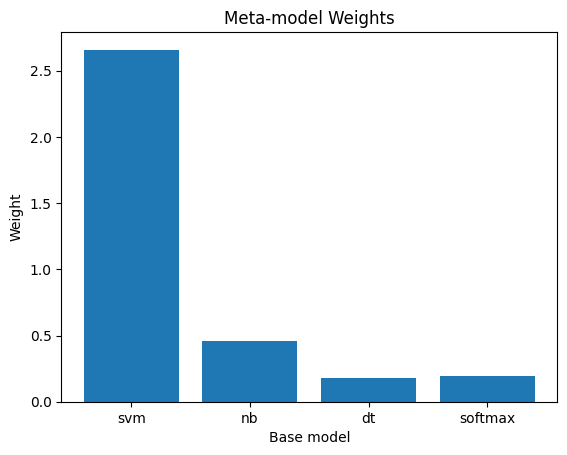

Bias (w0): -1.9718483147616983
svm : 2.6581832599004005
nb : 0.46026001470463895
dt : 0.18174002415519502
softmax : 0.19088680748126916


In [46]:
names = ["svm", "nb", "dt", "softmax"]
weights = w[1:]

plt.figure()
plt.bar(names, weights)
plt.xlabel("Base model")
plt.ylabel("Weight")
plt.title("Meta-model Weights")
plt.show()

print("Bias (w0):", float(w[0]))
for n, wi in zip(names, weights):
    print(n, ":", float(wi))
